In [ ]:
import torch
import torchaudio
import matplotlib
import matplotlib.pyplot as plt
import IPython
matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print('Sample rate: ', bundle.sample_rate)
print('Labels: ', bundle.get_labels())

Sample rate:  16000
Labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model = bundle.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:08<00:00, 42.8MB/s]


In [ ]:
SPEECH_FILE = './speech.wav'
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
print(sample_rate)

16000


In [ ]:
if sample_rate != bundle.sample_rate:
  waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
  features, _ = model.extract_features(waveform)

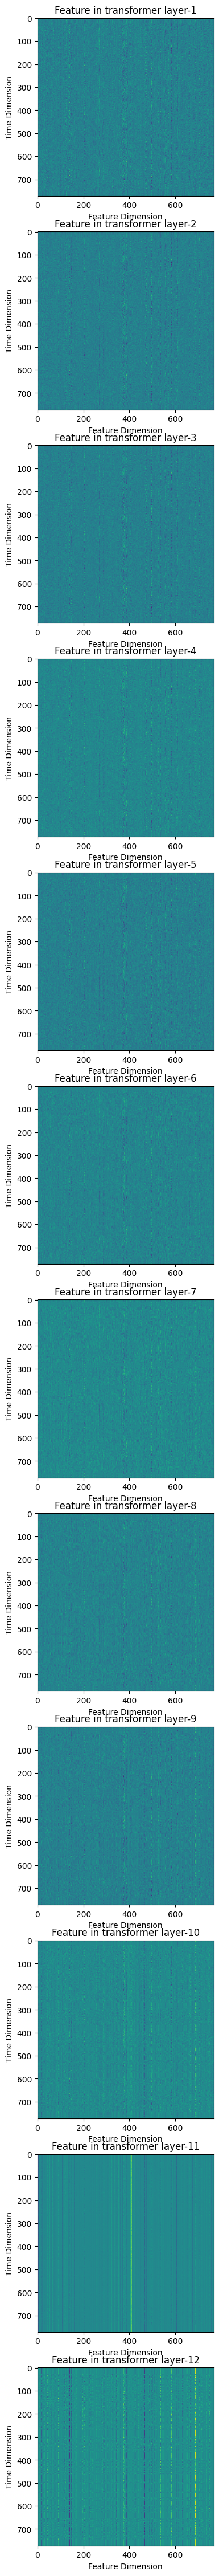

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.8*len(features)))
for i, feat in enumerate(features):
  ax[i].imshow(feat[0], interpolation='nearest')
  ax[i].set_title(f'Feature in transformer layer-{i+1}')
  ax[i].set_xlabel('Feature Dimension')
  ax[i].set_ylabel('Time Dimension')
plt.show()

In [ ]:
with torch.inference_mode():
  emission, _ = model(waveform)

In [ ]:
emission[0].T.shape

torch.Size([29, 773])

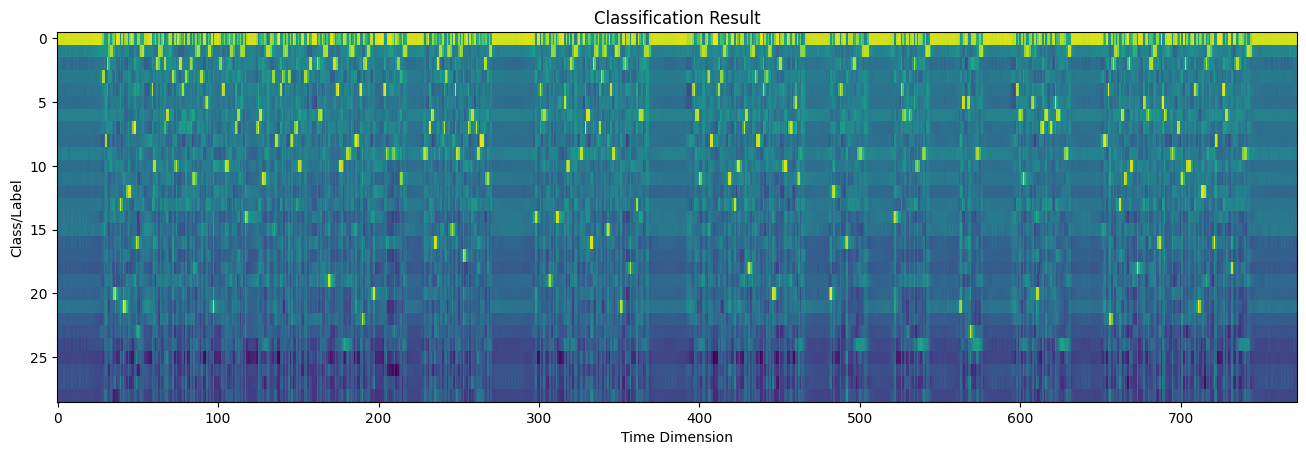

Labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].T, aspect='auto', interpolation='nearest')
plt.title('Classification Result')
plt.xlabel('Time Dimension')
plt.ylabel('Class/Label')
plt.show()

print('Labels: ', bundle.get_labels())

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
  def __init__(self, labels):
    super().__init__()
    self.labels = labels
    self.blank = 0

  def forward(self, emission: torch.Tensor) -> str:
    indices = torch.argmax(emission, dim=-1)
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i for i in indices if i != self.blank]
    return ''.join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
text = decoder(emission[0])

In [ ]:
print(text)

THE|PUBLIC|ARE|ENTREATED|TO|BEAR|IN|MIND|THAT|THIRTEEN|YEARS|HAVE|PASSED|SINCE|IT|WAS|FINISHED|MANY|MORE|SINCE|IT|WAS|BEGUN|AND|THAT|DURING|THAT|PERIOD|PLACES|MANNERS|BOOKS|AND|OPINIONS|HAVE|UNDERGONE|CONSIDERABLE|CHANGES|


In [ ]:
IPython.display.Audio(SPEECH_FILE)